In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
import os
import io
import re
import sys
import time
%matplotlib inline

In [2]:
IDS_df = pd.read_csv("../data/IDS-2018-multiclass.csv")

# To display the top 5 rows
# IDS_df.head(5)
IDS_df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

In [3]:
IDS_df = IDS_df.drop('timestamp', axis=1)
# IDS_df.columns

In [4]:
for i in range(len(IDS_df.columns)):
     print(IDS_df.columns[i], '-', IDS_df.dtypes[i])

dst_port - int64
protocol - int64
flow_duration - int64
tot_fwd_pkts - int64
tot_bwd_pkts - int64
totlen_fwd_pkts - float64
totlen_bwd_pkts - float64
fwd_pkt_len_max - float64
fwd_pkt_len_min - float64
fwd_pkt_len_mean - float64
fwd_pkt_len_std - float64
bwd_pkt_len_max - float64
bwd_pkt_len_min - float64
bwd_pkt_len_mean - float64
bwd_pkt_len_std - float64
flow_byts_s - float64
flow_pkts_s - float64
flow_iat_mean - float64
flow_iat_std - float64
flow_iat_max - float64
flow_iat_min - float64
fwd_iat_tot - float64
fwd_iat_mean - float64
fwd_iat_std - float64
fwd_iat_max - float64
fwd_iat_min - float64
bwd_iat_tot - float64
bwd_iat_mean - float64
bwd_iat_std - float64
bwd_iat_max - float64
bwd_iat_min - float64
fwd_psh_flags - int64
bwd_psh_flags - int64
fwd_urg_flags - int64
bwd_urg_flags - int64
fwd_header_len - int64
bwd_header_len - int64
fwd_pkts_s - float64
bwd_pkts_s - float64
pkt_len_min - float64
pkt_len_max - float64
pkt_len_mean - float64
pkt_len_std - float64
pkt_len_var - fl

In [5]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(413648, 79)


In [6]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

1900


In [7]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [8]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(412698, 79)


In [9]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


Examine the proportion of types of traffic:

In [10]:
IDS_df['label'].value_counts()

Benign                      199275
Infilteration                39777
Bot                          20000
DDoS attacks-LOIC-HTTP       20000
DDOS attack-HOIC             20000
DoS attacks-Hulk             20000
DoS attacks-GoldenEye        20000
SSH-Bruteforce               20000
DoS attacks-SlowHTTPTest     20000
FTP-BruteForce               19998
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Name: label, dtype: int64

Convert all non-normal observations into a single class:

In [11]:
def get_label(text):    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'DoS attacks-Slowloris':
        return 2
    elif text == 'SSH-Bruteforce':
        return 3
    elif text == 'DDOS attack-HOIC':
        return 4
    elif text == 'FTP-BruteForce':
        return 5
    elif text == 'DoS attacks-SlowHTTPTest':
        return 6
    elif text == 'Bot':
        return 7
    elif text == 'DoS attacks-Hulk':
        return 8
    elif text == 'DoS attacks-GoldenEye':
        return 9
    elif text == 'DDoS attacks-LOIC-HTTP':
        return 10
    elif text == 'DDOS attack-LOIC-UDP':
        return 11
    elif text == 'Brute Force -Web':
        return 12
    elif text == 'Brute Force -XSS':
        return 13
    elif text == 'SQL Injection':
        return 14

IDS_df["label"] = IDS_df["label"].apply(get_label)

In [12]:
#y = IDS_df["Label"].values
print(IDS_df["label"].value_counts())

0     199275
1      39777
10     20000
9      20000
8      20000
7      20000
6      20000
4      20000
3      20000
5      19998
2      10990
11      1730
12       611
13       230
14        87
Name: label, dtype: int64


Convert all categorical features into numerical form:

In [13]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        IDS_df[c] = encodings_dictionary[c].fit_transform(IDS_df[c])

Split the dataset into normal and abnormal observations:

In [14]:
IDS_df_normal = IDS_df[IDS_df["label"] == 0] #.sample(50000)  # Taking only 50000 samples to balance. Change this as required.
IDS_df_abnormal = IDS_df[IDS_df["label"] != 0]
y_normal = IDS_df_normal.pop("label").values
X_normal = IDS_df_normal.values
y_anomaly = IDS_df_abnormal.pop("label").values
X_anomaly = IDS_df_abnormal.values

Train-test split the dataset:

In [15]:
from sklearn.model_selection import train_test_split

X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=11)

X_anomaly_train, X_anomaly_test, y_anomaly_train, y_anomaly_test = train_test_split(
    X_anomaly, y_anomaly, test_size=0.2, random_state=11, stratify=y_anomaly)

import numpy as np

X_train = np.concatenate((X_normal_train, X_anomaly_train))
y_train = np.concatenate((y_normal_train, y_anomaly_train))
X_test = np.concatenate((X_normal_test, X_anomaly_test))
y_test = np.concatenate((y_normal_test, y_anomaly_test))

# X_train = np.concatenate((X_normal_train[:10000], X_anomaly_train[:10000]))
# y_train = np.concatenate((y_normal_train[:10000], y_anomaly_train[:10000]))
# X_test = np.concatenate((X_normal_test[:1000], X_anomaly_test[:1000]))
# y_test = np.concatenate((y_normal_test[:1000], y_anomaly_test[:1000]))

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(330158, 78)
(82540, 78)
(330158,)
(82540,)


In [17]:
batch_size = 1000

# Pytorch
X_train  = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train, y_train)
valid = torch.utils.data.TensorDataset(X_test, y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

print('Completed loading data')

Completed loading data


In [18]:
train_loader.dataset.tensors[0].shape

torch.Size([330158, 78])

In [19]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
        
# Defining the DNN model
input_size = train_loader.dataset.tensors[0].shape[1]
hidden_layers = [128]
output_size = 15

# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, hidden_layers[0])
        self.activ1 = nn.ReLU()
        
#         self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1])
#         self.activ2 = nn.ReLU()
        
#         self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2])
#         self.activ3 = nn.ReLU()
        
        self.layer2 = nn.Linear(hidden_layers[0], output_size)
        
    # forward propagate input
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        
        x = self.layer2(x)
#         x = self.activ2(x)
        
#         x = self.layer3(x)
#         x = self.activ3(x)
        
#         x = self.layer4(x)
        return x

model = MLP(input_size)
print(model)
model.to(device)

 # Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)
# Adam Optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

MLP(
  (layer1): Linear(in_features=78, out_features=128, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=128, out_features=15, bias=True)
)


In [20]:
print('Start training...')
start_time = time.time()
    
epochs = 50

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for e in range(epochs):
    for i, (data, labels) in enumerate(train_loader):
        train = data.to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()

        if count % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for data, labels in valid_loader:
                valid = data.to(device)                               
                labels = labels.to(device)

                # Forward propagation
                outputs = model(valid)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                #print('Predicted: ', predicted)
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Epoch: {} Iteration: {}  Loss: {}  Accuracy: {} %'.format(e + 1, count, loss.data, accuracy))

        count += 1

end_time = time.time()
print('Epochs completed. Time taken (seconds): ', str(end_time - start_time))
    

Start training...
Epoch: 1 Iteration: 0  Loss: 1176652.0  Accuracy: 15 %
Epoch: 2 Iteration: 500  Loss: 21952.84375  Accuracy: 65 %
Epoch: 4 Iteration: 1000  Loss: 6891.7578125  Accuracy: 66 %
Epoch: 5 Iteration: 1500  Loss: 2255.09912109375  Accuracy: 67 %
Epoch: 7 Iteration: 2000  Loss: 2808.266357421875  Accuracy: 70 %
Epoch: 8 Iteration: 2500  Loss: 3689.66845703125  Accuracy: 70 %
Epoch: 10 Iteration: 3000  Loss: 1584.7640380859375  Accuracy: 66 %
Epoch: 11 Iteration: 3500  Loss: 1561.7852783203125  Accuracy: 71 %
Epoch: 13 Iteration: 4000  Loss: 2451.412353515625  Accuracy: 71 %
Epoch: 14 Iteration: 4500  Loss: 1586.82861328125  Accuracy: 74 %
Epoch: 16 Iteration: 5000  Loss: 1501.1944580078125  Accuracy: 77 %
Epoch: 17 Iteration: 5500  Loss: 1598.2200927734375  Accuracy: 70 %
Epoch: 19 Iteration: 6000  Loss: 1011.4992065429688  Accuracy: 67 %
Epoch: 20 Iteration: 6500  Loss: 1148.776123046875  Accuracy: 77 %
Epoch: 22 Iteration: 7000  Loss: 2308.802978515625  Accuracy: 72 %
Epoc

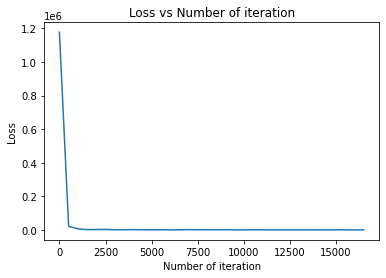

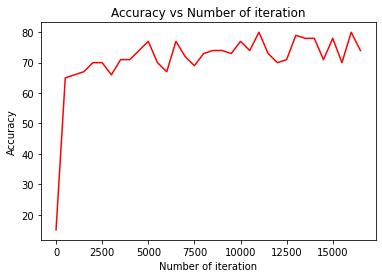

In [21]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.show()